In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import torch
from torch import nn, optim
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image

from gan import models, build_cycle_gan_trainer, kl_cycle_gan_loss_step
from utils.benchmark import train
from utils.display import display_images
from utils.checkpoints import load_checkpoint
from utils.datasets import DomainDataset
from __datasets__ import ITSDataset, DenseHazeCVPR2019Dataset

In [5]:
config = models.CycleGanConfig(
    "../../pytorch/datasets/celeb-a",
    "CycleGan-haze2clear",

    batch_size=8,
    norm=nn.InstanceNorm2d,
    writer=True,
    lr=2e-4,
    p=0,

    inp_channels=3,
    hidden_channels=64,
    out_channels=3,
    downsample=3,
    residuals=7,
    n=0,
    blocks=(64, 128, 256, 512, 1024),
)

In [6]:
ds = DomainDataset(
    ITSDataset(DIR="../../pytorch/datasets/its", SET="hazy", download=True, sub_sample=0.1,
               image_transform=T.Compose([
                   T.Resize((64, 64)),
                   T.ToTensor(),
                   T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   lambda x: x.to(config.device),
               ])),
    ITSDataset(DIR="../../pytorch/datasets/its", SET="clear", download=True, sub_sample=0.1,
               image_transform=T.Compose([
                   T.Resize((64, 64)),
                   T.ToTensor(),
                   T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   lambda x: x.to(config.device),
               ])),
)
len(ds), type(ds[0:1])

(1399, dict)

In [7]:
generatorA, generatorB, discriminatorA, discriminatorB = models.build_CycleGan(config)
optimizerG = optim.Adam(list(generatorA.parameters()) + list(generatorB.parameters()), lr=config.lr, betas=config.betas)
optimizerD = optim.Adam(list(discriminatorA.parameters()) + list(discriminatorB.parameters()), lr=config.lr,
                        betas=config.betas)

In [8]:
if input("Load Model[y|n]?> ").lower() == "y":
    others = load_checkpoint(
        input("path?> "),
        {
            "generatorA": generatorA,
            "generatorB": generatorB,
            "discriminatorA": discriminatorA,
            "discriminatorB": discriminatorB
        },
        {
            "optimizerG": optimizerG,
            "optimizerD": optimizerD,
        }
    )
    step_offset = others["step"]
else:
    step_offset = 0
step_offset

0

In [12]:
def data_extractor(DATA):
    realA, realB = DATA["domain_0"]["image"], DATA["domain_1"]["image"]
    return realA, realB

fixed_inp = ds[0:9]["domain_0"]["image"], ds[0:9]["domain_1"]["image"]
trainer = build_cycle_gan_trainer(
    generatorA, generatorB, discriminatorA, discriminatorB,
    optimizerG, optimizerD,
    kl_cycle_gan_loss_step,
    data_extractor,
    config.writer, 100, fixed_inp,
    save_path=None, save_period=500 * config.batch_size
)

In [13]:
print((fake := generatorA(fixed_inp[0])).cpu().shape, discriminatorA(fake).shape)
print((fake := generatorB(fixed_inp[1])).cpu().shape, discriminatorB(fake).shape)

torch.Size([9, 3, 64, 64]) torch.Size([9, 1, 2, 2])
torch.Size([9, 3, 64, 64]) torch.Size([9, 1, 2, 2])


In [15]:
generatorA = generatorA.train()
generatorB = generatorB.train()
discriminatorA = discriminatorA.train()
discriminatorB = discriminatorB.train()
step_offset = train(
    trainer, ds,
    ne=1, bs=config.batch_size,
    step_offset=step_offset,
)
step_offset

Epoch: 0/1 | Batch 0/175|          |  0% [00:00<?, ?it/s ]

KeyboardInterrupt: 

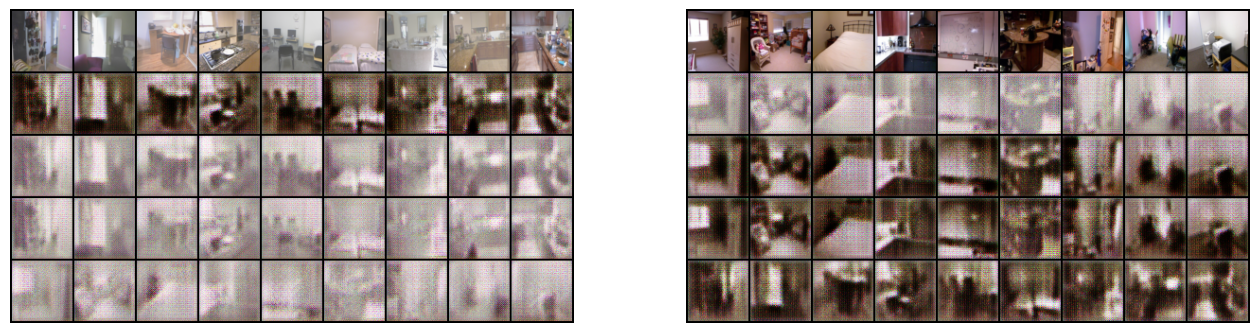

CPU times: user 537 ms, sys: 798 ms, total: 1.33 s
Wall time: 1.79 s


In [18]:
%%time

generatorA = generatorA.eval()
generatorB = generatorB.eval()
discriminatorA = discriminatorA.eval()
discriminatorB = discriminatorB.eval()
with torch.inference_mode():
    realA, realB = fixed_inp
    fakeA, fakeB = generatorA(realB), generatorB(realA)
    backA, backB = generatorB(fakeA), generatorA(fakeB)
    sameA, sameB = generatorA(realA), generatorB(realB)
    doubleA, doubleB = generatorA(fakeA), generatorB(fakeB)
    gridA = make_grid(torch.cat([realA, fakeB, backB, sameA, doubleA], dim=0), nrow=len(realA), normalize=True)
    gridB = make_grid(torch.cat([realB, fakeA, backA, sameB, doubleB], dim=0), nrow=len(realB), normalize=True)
display_images(torch.stack([gridA, gridB]).cpu().permute(0, 2, 3, 1))

In [14]:
save_image(gridA, "gridA.png"); save_image(gridB, "gridB.png")